In [1]:
from gampixpy import detector, input_parsing, config
from gampixpy.units import *
import numpy as np
import scipy.stats as st
import h5py
import torch

In [2]:
# load config files
detector_config = config.DetectorConfig('./far_detector_vd.yaml')
physics_config = config.default_physics_params
readout_config = config.ReadoutConfig('../gampixpy/readout_config/GAMPixD.yaml')

# load detector sim output file
# full sim with (supposedly) vertex tagging
sim_output = h5py.File('/sdf/data/neutrino/dougl215/gampixpy/rad/rad_fullgeoanatruth-vd-reduced_g4_00_2Mhz_full_timefix.h5')
# 5 events sim with (supposedly) vertex tagging
#sim_output = h5py.File('./rad_fullgeoanatruth-vd-reduced_g4_test.h5')
print (sim_output['pixel_hits'].dtype)

# get an event from the output
event_id = 1
event_pixel_hit_mask = sim_output['pixel_hits']['event id'] == event_id
event_pixel_hits = sim_output['pixel_hits'][event_pixel_hit_mask]

event_coarse_hit_mask = sim_output['coarse_hits']['event id'] == event_id
event_coarse_hits = sim_output['coarse_hits'][event_coarse_hit_mask]

event_meta_mask = sim_output['meta']['event id'] == event_id
event_meta = sim_output['meta'][event_meta_mask]

print (event_coarse_hits.dtype)

[('event id', '<u4'), ('pixel tpc', '<u4'), ('pixel x', '<f4'), ('pixel y', '<f4'), ('hit z', '<f4'), ('hit t', '<f4'), ('hit charge', '<f4'), ('attribution', '<f4', (3,)), ('label', '<i4', (3,))]
[('event id', '<u4'), ('tile tpc', '<u4'), ('tile x', '<f4'), ('tile y', '<f4'), ('hit z', '<f4'), ('hit t', '<f4'), ('hit charge', '<f4'), ('attribution', '<f4', (3,)), ('label', '<i4', (3,))]


In [3]:
# let's look at the first coarse tile sample
print(event_coarse_hits[0]['hit charge'],
      event_coarse_hits[0]['label'],
      event_coarse_hits[0]['attribution'])
print (np.unique(event_coarse_hits['label']))

22046.91 [ 3289 -9999 -9999] [1.0000001 0.        0.       ]
[-9999  2167  2169  2170  2172  2173  2174  2175  2176  2177  2179  2181
  2183  2184  2185  2186  2187  2188  2189  2190  2191  2193  2194  2195
  2196  2197  2198  2199  2200  2202  2205  2206  2207  2208  2209  2210
  2211  2212  2214  2215  2216  2217  2219  2220  2221  2222  2224  2225
  2226  2228  2229  2232  2233  2235  2236  2237  2238  2239  2240  2242
  2243  2245  2246  2248  2249  2250  2251  2252  2253  2254  2255  2256
  2258  2260  2261  2262  2263  2264  2266  2267  2268  2270  2271  2272
  2273  2274  2275  2276  2277  2278  2279  2280  2282  2283  2284  2287
  2288  2289  2290  2291  2292  2293  2294  2295  2296  2297  2298  2299
  2301  2302  2303  2304  2306  2307  2308  2310  2312  2313  2314  2315
  2316  2317  2318  2319  2321  2322  2323  2325  2327  2328  2329  2330
  2331  2332  2333  2334  2335  2336  2337  2338  2339  2340  2341  2343
  2344  2345  2346  2347  2348  2349  2351  2352  2353  2354  2

In [4]:
# and also the first pixel sample
print(event_pixel_hits[0]['hit charge'],
      event_pixel_hits[0]['label'],
      event_pixel_hits[0]['attribution'])
print (np.unique(event_pixel_hits['label']))

-7.06214 [ 3289 -9999 -9999] [0. 0. 0.]
[-9999  2167  2169  2170  2172  2173  2174  2175  2176  2177  2179  2181
  2184  2185  2186  2188  2189  2190  2191  2193  2194  2195  2196  2197
  2199  2200  2202  2205  2206  2207  2208  2209  2210  2211  2212  2214
  2215  2216  2217  2219  2220  2221  2222  2224  2225  2226  2228  2229
  2232  2233  2235  2236  2238  2239  2240  2242  2243  2245  2246  2248
  2250  2251  2252  2253  2254  2255  2258  2260  2261  2262  2263  2264
  2266  2267  2268  2270  2271  2272  2273  2275  2276  2277  2278  2279
  2280  2282  2283  2284  2287  2289  2290  2291  2292  2293  2294  2295
  2296  2297  2298  2301  2302  2304  2306  2307  2308  2312  2314  2315
  2316  2317  2318  2319  2321  2322  2323  2325  2327  2328  2329  2330
  2331  2332  2333  2334  2335  2336  2339  2340  2341  2343  2344  2345
  2346  2347  2348  2349  2352  2353  2354  2357  2359  2360  2361  2363
  2365  2366  2368  2369  2371  2372  2373  2375  2376  2377  2380  2382
  2383  238

In [5]:
# we want to examine the input segments that correspond to a single vertex
# first, get the segments associated with this event ID
infile_path = '/sdf/data/neutrino/yuntse/lartpc_rd/gampix/g4/rad/fullgeoanatruth-vd-reduced_g4_00.h5'
input_edepsim = h5py.File(infile_path)

event_segment_mask = input_edepsim['segments']['event_id'] == event_id
event_segments = input_edepsim['segments'][event_segment_mask]

event_segment_start = np.stack([event_segments['x_start']*cm,
                                event_segments['y_start']*cm,
                                event_segments['z_start']*cm]).T
event_segment_stop = np.stack([event_segments['x_end']*cm,
                               event_segments['y_end']*cm,
                               event_segments['z_end']*cm]).T
event_segment_t_start = event_segments['t0_start']*us
event_segment_t_stop = event_segments['t0_end']*us
event_segment_dE = event_segments['dE']*MeV
event_segment_label = event_segments['file_vertex_id']

print (event_segment_label)

[2167 2168 2169 ... 4226 4226 4226]


In [6]:
# let's look at a single vertex at a time
# choose one label ID
label_selection = 2732

# reduce the attributions down to the single largest contributor
majority_vertex_contrib = np.array([this_pixel_hit['label'][np.argmax(this_pixel_hit['attribution'])] for this_pixel_hit in event_pixel_hits])

print (np.unique(majority_vertex_contrib))
vertex_hit_mask = majority_vertex_contrib == label_selection
# get just the pixel hits for which this vertex is the greatest contributor
vertex_hits = np.array(event_pixel_hits)[vertex_hit_mask]

label_mask = event_segment_label == label_selection
print ("found ", str(sum(label_mask).item()), " segments belonging to this vertex")
# get the segment start/end positions for this vertex, too
vertex_segment_start = event_segment_start[label_mask]
vertex_segment_stop = event_segment_stop[label_mask]
vertex_segment_t_start = event_segment_t_start[label_mask]

depth = np.dot(vertex_segment_start - detector_config['drift_volumes']['volume_0']['anode_center'].numpy(), detector_config['drift_volumes']['volume_0']['drift_axis'])
print ("depth:", depth[0], "cm")

[2167 2169 2170 2172 2173 2174 2175 2176 2177 2179 2181 2184 2185 2186
 2188 2189 2190 2191 2193 2194 2195 2196 2197 2199 2200 2202 2205 2206
 2207 2208 2209 2210 2211 2212 2214 2215 2216 2217 2219 2220 2221 2222
 2224 2225 2226 2228 2229 2232 2233 2235 2236 2238 2239 2240 2242 2243
 2245 2246 2248 2250 2251 2252 2253 2254 2255 2258 2260 2261 2262 2263
 2264 2266 2267 2268 2270 2271 2272 2273 2275 2276 2277 2278 2279 2280
 2282 2283 2284 2287 2289 2290 2291 2292 2293 2294 2295 2296 2297 2298
 2301 2302 2304 2306 2307 2308 2312 2314 2315 2316 2317 2318 2319 2321
 2322 2323 2325 2327 2328 2329 2330 2331 2332 2333 2334 2335 2336 2339
 2340 2341 2343 2344 2345 2346 2347 2348 2349 2352 2353 2354 2357 2359
 2360 2361 2363 2365 2366 2368 2369 2371 2372 2373 2375 2376 2377 2380
 2382 2383 2384 2386 2388 2389 2391 2393 2394 2395 2396 2397 2398 2399
 2401 2403 2404 2405 2406 2407 2409 2410 2413 2414 2416 2417 2418 2419
 2420 2422 2424 2425 2426 2429 2430 2431 2432 2433 2434 2435 2436 2438
 2439 

In [7]:
# some plotting utilities
import SLACplots
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt

pixel_hit_kwargs = dict(facecolors=SLACplots.stanford.illuminating,
                        linewidths=1,
                        edgecolors=SLACplots.stanford.illuminating,
                        alpha = 0.01)
TPC_boundary_kwargs = dict(facecolors=None,
                           linewidths=1,
                           edgecolors=SLACplots.stanford.full_palette['Black']['50%'],
                           linestyle = '--',
                           alpha = 0)

# draw box-like shapes in 3d
def draw_box_from_corners(ax, corners, **kwargs):
    bottom_face = np.array([corners[0],
                            corners[1],
                            corners[3],
                            corners[2],
                            corners[0],
                            ])
    top_face = np.array([corners[4],
                         corners[5],
                         corners[7],
                         corners[6],
                         corners[4],
                         ])
    left_face = np.array([corners[0],
                          corners[1],
                          corners[5],
                          corners[4],
                          corners[0],
                          ])
    right_face = np.array([corners[2],
                           corners[3],
                           corners[7],
                           corners[6],
                           corners[2],
                           ])
    front_face = np.array([corners[0],
                           corners[2],
                           corners[6],
                           corners[4],
                           corners[0],
                           ])
    back_face = np.array([corners[1],
                          corners[3],
                          corners[7],
                          corners[5],
                          corners[1],
                          ])
    faces = [bottom_face,
             top_face,
             left_face,
             right_face,
             back_face,
             front_face,
             ]

    ax.add_collection3d(Poly3DCollection(faces, **kwargs))

from gampixpy import coordinates
coordinate_manager = coordinates.CoordinateManager(detector_config)

# plot hits in experimental coordinates as boxes
def plot_hit(ax, this_hit, z_offset = 0):
    cell_tpc = this_hit['pixel tpc']
    cell_center_x = this_hit['pixel x']
    cell_center_y = this_hit['pixel y']
    cell_center_z = this_hit['hit z']

    tpc_ind = torch.tensor(cell_tpc, dtype = torch.double)
    tpc_coords = torch.tensor([cell_center_x,
                               cell_center_y,
                               cell_center_z + z_offset])

    exp_coords = coordinate_manager.to_experiment_coords(tpc_coords, tpc_ind)
    exp_coords = exp_coords.cpu().numpy()[0]

    pitch = readout_config['pixels']['pitch']

    this_volume_dict = detector_config['drift_volumes'][coordinate_manager.index_to_volume[cell_tpc]]
    horizontal_axis = this_volume_dict['anode_horizontal'].cpu().numpy()
    half_span_horizontal = horizontal_axis*pitch/2

    vertical_axis = this_volume_dict['anode_vertical'].cpu().numpy()
    half_span_vertical = vertical_axis*pitch/2

    drift_axis = this_volume_dict['drift_axis'].cpu().numpy()
    v = physics_config['charge_drift']['drift_speed']
    cell_hit_length = v*readout_config['pixels']['clock_interval']
    depth_span = drift_axis*cell_hit_length

    corners = [exp_coords - half_span_horizontal - half_span_vertical,
               exp_coords - half_span_horizontal + half_span_vertical,
               exp_coords + half_span_horizontal - half_span_vertical,
               exp_coords + half_span_horizontal + half_span_vertical,
               exp_coords - half_span_horizontal - half_span_vertical + depth_span,
               exp_coords - half_span_horizontal + half_span_vertical + depth_span,
               exp_coords + half_span_horizontal - half_span_vertical + depth_span,
               exp_coords + half_span_horizontal + half_span_vertical + depth_span,
              ]
            
    draw_box_from_corners(ax, corners,
                         **pixel_hit_kwargs)

def plot_volumes(ax):
    for volume_name, volume_dict in detector_config['drift_volumes'].items():
            corners = [corner.cpu().numpy() for corner in volume_dict['anode_corners']] \
            + [corner.cpu().numpy() for corner in volume_dict['cathode_corners']]
            print (corners)
            draw_box_from_corners(ax, corners, **TPC_boundary_kwargs)

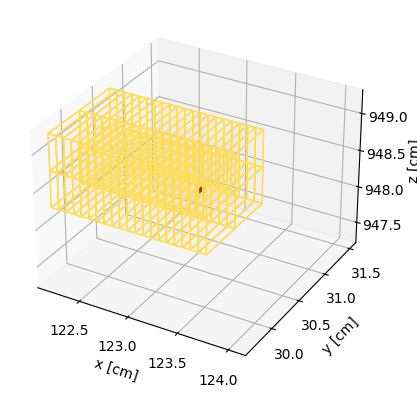

In [43]:
# display the G4 segments and the corresponding hit objects
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

ax.set_xlabel(r'x [cm]')
ax.set_ylabel(r'y [cm]')
ax.set_zlabel(r'z [cm]')

for seg_start, seg_stop in zip(vertex_segment_start,
                               vertex_segment_stop):
    seg = np.stack((seg_start, seg_stop))
    ax.plot(*seg.T,
            color = SLACplots.stanford.cardinal_red)
    ax.scatter(*seg_start, 
               color = SLACplots.stanford.cardinal_red)
    ax.scatter(*seg_stop, 
               color = SLACplots.stanford.cardinal_red)
    
# since we don't have a way to measure the time of ionization, 
# let's cheat and figure out the depth offset based on the true
# ionization time.
# This only makes sense to do for a diagnostic plot.
v = physics_config['charge_drift']['drift_speed']
z_offset = torch.tensor(-vertex_segment_t_start[0]*v).float()

for this_hit in vertex_hits:
    plot_hit(ax, this_hit, 
             z_offset = z_offset,
            )

plot_lim_margin = 1
ax.set_xlim(ax.get_xlim()[0]-plot_lim_margin,
            ax.get_xlim()[1]+plot_lim_margin)
ax.set_ylim(ax.get_ylim()[0]-plot_lim_margin,
            ax.get_ylim()[1]+plot_lim_margin)
ax.set_zlim(ax.get_zlim()[0]-plot_lim_margin,
            ax.get_zlim()[1]+plot_lim_margin)
    
# un-comment to show the TPC volume boundaries
#plot_volumes(ax)
plt.show()

In [9]:
# let's get the relevant info from the hits for this vertex
# we can measure the pixel position (x-y in TPC coordinates)
# we can also measure the timestamp (assume we don't know t0)
# and the measured charge per hit
hit_x = np.array([this_hit['pixel x'] for this_hit in vertex_hits])
hit_y = np.array([this_hit['pixel y'] for this_hit in vertex_hits])
hit_t = np.array([this_hit['hit t'] for this_hit in vertex_hits])
hit_q = np.array([this_hit['hit charge'] for this_hit in vertex_hits])

estimated t center 2.204712


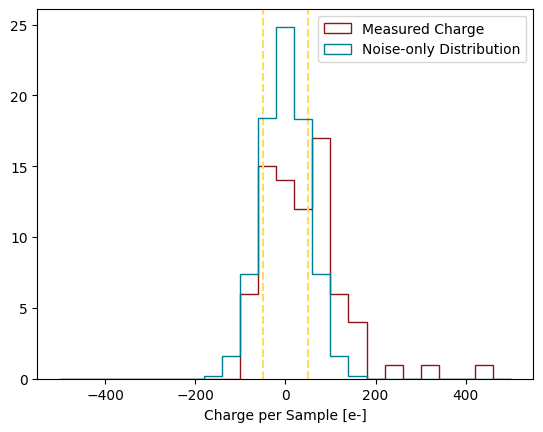

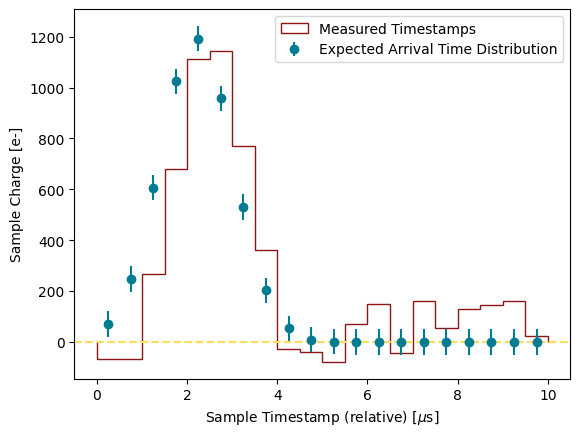

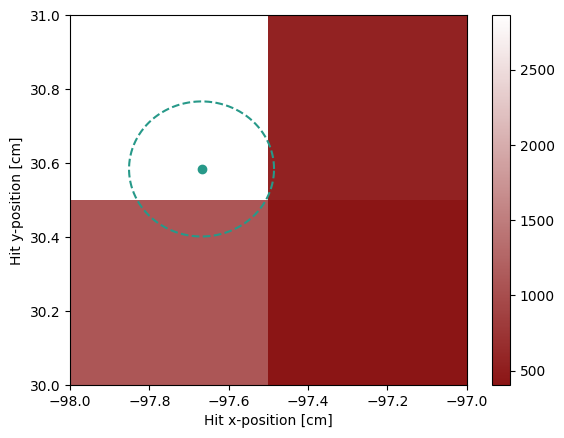

In [10]:
# make some plots of the distributions

# for measured charge, we expect to see most hits are just noise, 
# with one or two hits containing nearly all of the charge
# with diffusion, this charge-sharing between measurement regions
# should become more important
plt.figure()
# plot the measured hit charge
plt.hist(hit_q,
         histtype = 'step',
         #bins = np.logspace(1, 3, 26),
         bins = np.linspace(-500, 500, 26),
         label = 'Measured Charge')
# plot the average noise value
plt.axvline(x = -readout_config['pixels']['noise'],
            ls = '--',
            color = SLACplots.stanford.illuminating)
plt.axvline(x = readout_config['pixels']['noise'],
            ls = '--',
            color = SLACplots.stanford.illuminating)
# plot the expected distribution for a noise-only measurement
N_samples = 10000000
plt.hist(st.norm.rvs(loc = 0, scale=readout_config['pixels']['noise'], size = N_samples),
         histtype = 'step',
         #bins = np.logspace(1, 3, 26),
         bins = np.linspace(-500, 500, 26),
         label = 'Noise-only Distribution',
         weights = hit_q.shape[0]/N_samples*np.ones(N_samples),
        )
plt.legend()
#plt.semilogx()
plt.xlabel(r'Charge per Sample [e-]')

# plot the distribution of charge arrival time 
plt.figure()
n_t_bins = int((np.max(hit_t) - np.min(hit_t))/readout_config['pixels']['clock_interval']) + 1
last_time_tick = n_t_bins*readout_config['pixels']['clock_interval']
t_bins = np.linspace(0, last_time_tick, n_t_bins + 1)
t_bin_centers = 0.5*(t_bins[:-1] + t_bins[1:])

plt.hist(hit_t - np.min(hit_t),
         histtype = 'step',
         weights = hit_q,
         bins = t_bins,
         label = 'Measured Timestamps')

# estimate the center of signal charge
# only consider hits which are 5x the noise level
above_threshold_mask = hit_q > 5*readout_config['pixels']['noise']
t_center = np.sum(hit_t[above_threshold_mask]*hit_q[above_threshold_mask])/np.sum(hit_q[above_threshold_mask]) - np.min(hit_t)
print ("estimated t center", t_center)
v = physics_config['charge_drift']['drift_speed']
width_longitudinal = np.sqrt(2*physics_config['charge_drift']['diffusion_longitudinal']*(depth/v))
width_transverse = np.sqrt(2*physics_config['charge_drift']['diffusion_transverse']*(depth/v))
t_width = width_longitudinal/v

pmf = st.norm.cdf(t_bins[1:], loc = t_center, scale = t_width) - st.norm.cdf(t_bins[:-1], loc = t_center, scale = t_width)
pmf *= sum(hit_q)

plt.errorbar(t_bin_centers,
             pmf,
             yerr = readout_config['pixels']['noise']*np.ones_like(pmf),
             fmt = 'o',
             label = 'Expected Arrival Time Distribution'
            )
plt.axhline(y = 0, ls = '--', color = SLACplots.stanford.illuminating)
plt.legend()
plt.xlabel(r'Sample Timestamp (relative) [$\mu$s]')
plt.ylabel(r'Sample Charge [e-]')

# plot the distribution of charge arrival position
plt.figure()
pitch = readout_config['pixels']['pitch']
plt.hist2d(hit_x, hit_y,
           bins = (np.linspace(np.min(hit_x) - 0.5*pitch, 
                               np.max(hit_x) + 0.5*pitch, 
                               int((np.max(hit_x) - np.min(hit_x))/pitch + 2)),
                   np.linspace(np.min(hit_y) - 0.5*pitch, 
                               np.max(hit_y) + 0.5*pitch, 
                               int((np.max(hit_y) - np.min(hit_y))/pitch + 2))),
           weights = hit_q)
ax = plt.gca()
for seg_start, seg_stop in zip(vertex_segment_start,
                               vertex_segment_stop):
    seg = np.stack((seg_start, seg_stop))
    x_tpc = np.dot(seg_start - detector_config['drift_volumes']['volume_0']['anode_center'].numpy(), detector_config['drift_volumes']['volume_0']['anode_horizontal'].numpy())
    y_tpc = np.dot(seg_start - detector_config['drift_volumes']['volume_0']['anode_center'].numpy(), detector_config['drift_volumes']['volume_0']['anode_vertical'].numpy())
    ax.scatter(x_tpc, y_tpc, color = SLACplots.stanford.palo_verde)
    theta = np.linspace(0, np.pi*2, 1000)[:-1]
    ax.plot(x_tpc + np.cos(theta)*width_transverse,
            y_tpc + np.sin(theta)*width_transverse,
            ls = '--',
            color = SLACplots.stanford.palo_verde,
           )

plt.xlabel(r'Hit x-position [cm]')
plt.ylabel(r'Hit y-position [cm]')
plt.colorbar()

In [11]:
print (vertex_segment_start, vertex_segment_stop)
print (detector_config['drift_volumes']['volume_0']['anode_center'])
print (detector_config['drift_volumes']['volume_0']['drift_axis'])
# find the depth by taking dot(position_from_anode, drift_axis)
np.dot(vertex_segment_start - detector_config['drift_volumes']['volume_0']['anode_center'].numpy(), detector_config['drift_volumes']['volume_0']['drift_axis'].numpy())

[[123.10395   30.583769 948.27136 ]] [[123.12329   30.576824 948.2566  ]]
tensor([ 325.0000,    0.0000, 1045.9399])
tensor([-1.,  0.,  0.])


array([201.89606], dtype=float32)